<a href="https://colab.research.google.com/github/karlriis/trajectory-forecasting/blob/main/Edinburgh_NN_over_all_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/crowdbotp/OpenTraj.git

Cloning into 'OpenTraj'...
remote: Enumerating objects: 17725, done.
remote: Counting objects: 100% (1526/1526), done.
remote: Compressing objects: 100% (826/826), done.
remote: Total 17725 (delta 807), reused 1355 (delta 683), pack-reused 16199
Receiving objects: 100% (17725/17725), 390.77 MiB | 14.14 MiB/s, done.
Resolving deltas: 100% (1245/1245), done.
Checking out files: 100% (15796/15796), done.


In [ ]:
! pip install pykalman

     |████████████████████████████████| 228 kB 5.2 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=a6408475d48be12fc9015b5cfc47676fb5b7fcc7ef9db6417e97e2daca963652
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman


In [ ]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.getcwd()) + '/OpenTraj/opentraj/') # Anaconda python can't find the toolkit path without this for some reason

from toolkit.loaders.loader_edinburgh import load_edinburgh
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)

In [ ]:
opentraj_root = './OpenTraj/'
selected_day = '01Sep' # 3 days of data in total, ['01Jul', '01Aug', '01Sep']
edinburgh_path = os.path.join(opentraj_root, 'datasets/Edinburgh/annotations', 'tracks.%s.txt' % selected_day)
traj_dataset = load_edinburgh(edinburgh_path, title="Edinburgh", 
                              use_kalman=False, scene_id=selected_day, sampling_rate=4)

/content/OpenTraj/opentraj/toolkit/loaders/loader_edinburgh.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(file, sep="\n|=", header=None,index_col=None)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|██████████| 2342/2342 [05:16<00:00,  7.40it/s]


Warning! too big dt in [Edinburgh]
finish


In [ ]:
data = traj_dataset.data
NUM_OF_STEPS = 5

# Removing any agents which don't have enough steps for model fitting and predicting
agent_ids = data.agent_id.unique()
for agent_id in agent_ids:
    if len(data[data.agent_id == agent_id]) < 2*NUM_OF_STEPS:
        data = data[data.agent_id != agent_id]
agent_ids = data.agent_id.unique()

In [ ]:
# 'Normalize' the data so that all trajectories will begin at x=0, y=0
for agent_id in agent_ids:
    first_x = data[data.agent_id == agent_id]['pos_x'].iloc[0]
    first_y = data[data.agent_id == agent_id]['pos_y'].iloc[0]
    
    data.loc[data.agent_id == agent_id, 'pos_x'] = data[data.agent_id == agent_id]['pos_x'] - first_x
    data.loc[data.agent_id == agent_id, 'pos_y'] = data[data.agent_id == agent_id]['pos_y'] - first_y

In [ ]:
# Select the useful columns from the dataset
data = data[['index', 'agent_id', 'pos_x', 'pos_y']]

In [ ]:
from sklearn.model_selection import train_test_split
train_agent_ids, test_agent_ids = train_test_split(agent_ids, test_size=0.2)

### Helper functions

In [ ]:
def create_dataset(data, agent_ids):
    dataX, dataY = [], []
    for agent_id in agent_ids:
        x = data[data['agent_id'] == agent_id].iloc[:5][['pos_x', 'pos_y']]
        y = data[data['agent_id'] == agent_id].iloc[5][['pos_x', 'pos_y']]
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)
    
def calculate_error(pred_x, pred_y, test_x, test_y):
    
    # FDE
    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    # MSE
    abs_error_x = pred_x - test_x
    abs_error_y = pred_y - test_y
    
    MSE = np.mean(np.square(abs_error_x)) + np.mean(np.square(abs_error_y))
    
    return FDE, MSE

In [ ]:
train = create_dataset(data, train_agent_ids)
test = create_dataset(data, test_agent_ids)

In [ ]:
from keras.models import Model
from keras.layers import *    

inp = Input((5,2))

x = Flatten()(inp)

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)

out1 = Dense(1, activation='linear')(x)    
out2 = Dense(1, activation='linear')(x)

model = Model(inputs=inp, outputs=[out1,out2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'mean_squared_error')

In [ ]:
sep_y_train_data = np.hsplit(train[1], 2) # separate the y data into pieces to only provide 1 point as NN output
model.fit(train[0], [sep_y_train_data[0], sep_y_train_data[1]], epochs=400, batch_size=32, verbose=2)

Epoch 1/400
50/50 - 1s - loss: 4.9661 - dense_43_loss: 2.1669 - dense_44_loss: 2.7992 - 834ms/epoch - 17ms/step
Epoch 2/400
50/50 - 0s - loss: 1.9116 - dense_43_loss: 1.1469 - dense_44_loss: 0.7647 - 92ms/epoch - 2ms/step
Epoch 3/400
50/50 - 0s - loss: 0.7111 - dense_43_loss: 0.4007 - dense_44_loss: 0.3104 - 93ms/epoch - 2ms/step
Epoch 4/400
50/50 - 0s - loss: 0.3300 - dense_43_loss: 0.1452 - dense_44_loss: 0.1848 - 101ms/epoch - 2ms/step
Epoch 5/400
50/50 - 0s - loss: 0.2588 - dense_43_loss: 0.1089 - dense_44_loss: 0.1499 - 90ms/epoch - 2ms/step
Epoch 6/400
50/50 - 0s - loss: 0.2341 - dense_43_loss: 0.0980 - dense_44_loss: 0.1360 - 91ms/epoch - 2ms/step
Epoch 7/400
50/50 - 0s - loss: 0.2191 - dense_43_loss: 0.0927 - dense_44_loss: 0.1264 - 102ms/epoch - 2ms/step
Epoch 8/400
50/50 - 0s - loss: 0.2058 - dense_43_loss: 0.0880 - dense_44_loss: 0.1178 - 94ms/epoch - 2ms/step
Epoch 9/400
50/50 - 0s - loss: 0.1899 - dense_43_loss: 0.0807 - dense_44_loss: 0.1092 - 89ms/epoch - 2ms/step
Epoch 

In [ ]:

trainScore = model.evaluate(train[0], [sep_y_train_data[0], sep_y_train_data[1]], verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], np.sqrt(trainScore[0])))

sep_y_test_data = np.hsplit(test[1], 2)
testScore = model.evaluate(test[0], [sep_y_test_data[0], sep_y_test_data[1]], verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], np.sqrt(testScore[0])))

Train Score: 0.19 MSE (0.44 RMSE)
Test Score: 0.16 MSE (0.40 RMSE)


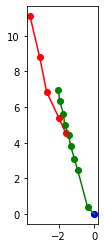

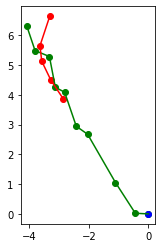

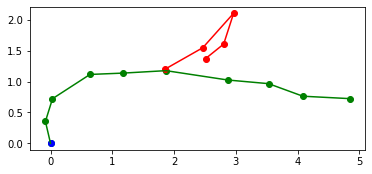

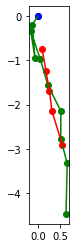

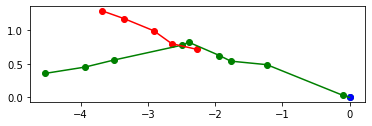

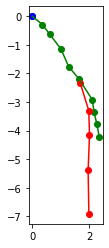

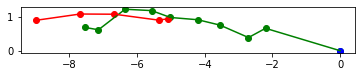

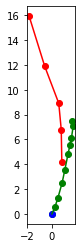

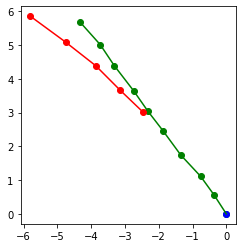

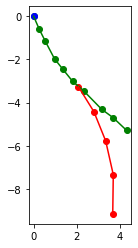

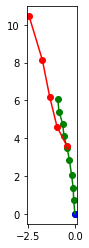

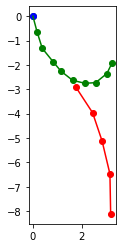

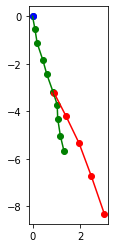

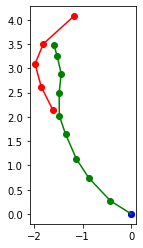

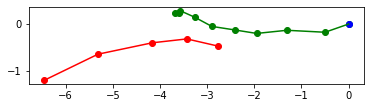

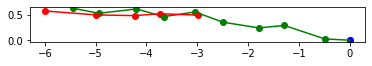

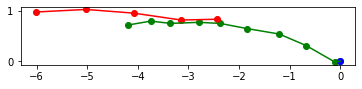

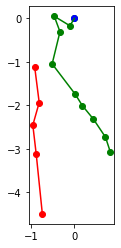

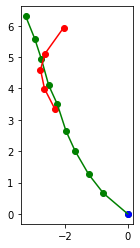

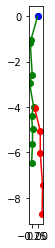

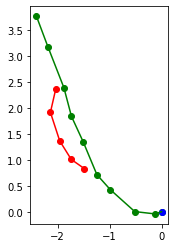

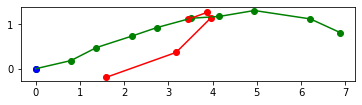

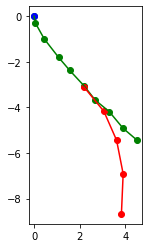

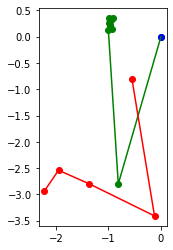

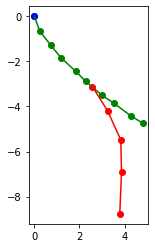

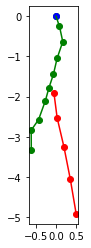

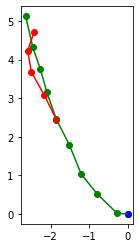

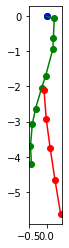

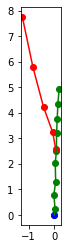

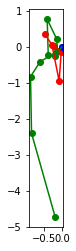

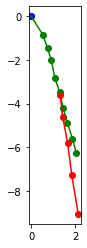

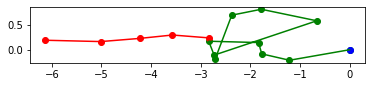

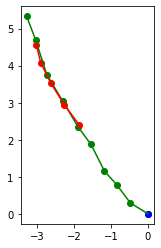

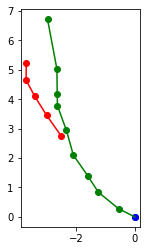

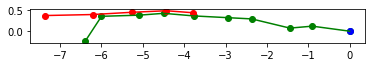

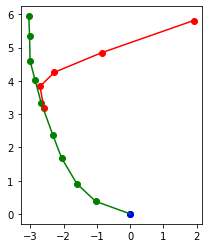

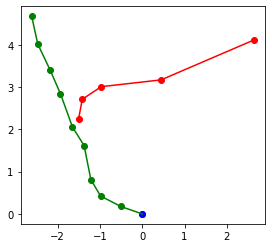

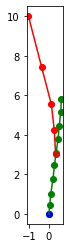

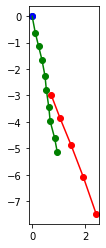

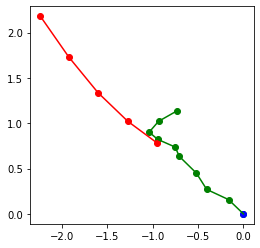

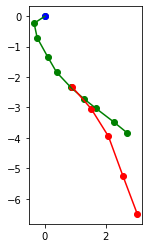

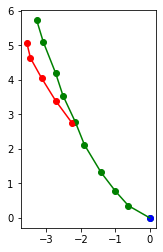

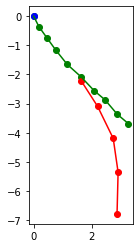

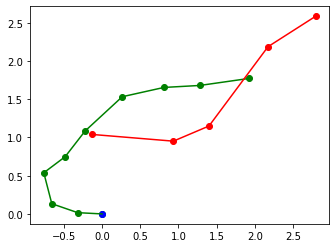

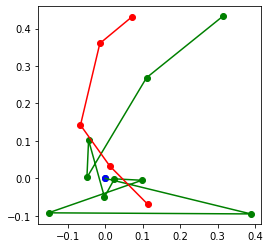

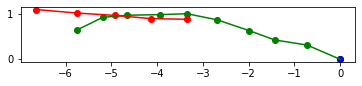

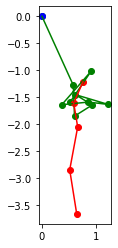

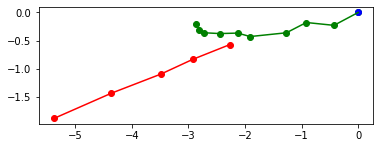

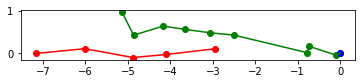

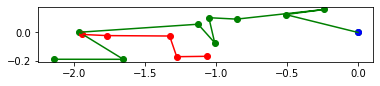

Average FDE:  2.6522484642238044


In [ ]:
all_FDE = []
plotting = True
for idx, agent_id in enumerate(test_agent_ids):

  seen_x = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_x'])
  seen_y = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_y'])
  unseen_x = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_x'])
  unseen_y = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_y'])

  rolling_x = np.array(seen_x)
  rolling_y = np.array(seen_y)
  for i in range(5):
    seen_coordinates = np.column_stack((rolling_x, rolling_y))
    pred_x, pred_y = model.predict(np.array([seen_coordinates]))

    rolling_x = np.append(rolling_x[1:], [pred_x[0]])
    rolling_y = np.append(rolling_y[1:], [pred_y[0]])
  
  FDE = np.sqrt((rolling_x[-1] - unseen_x[-1])**2 + (rolling_y[-1] - unseen_y[-1])**2)
  all_FDE.append(FDE)
  # plot data
  if plotting and idx < 50:
    plt.axes().set_aspect('equal')

    plt.plot(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')
    plt.scatter(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')

    plt.plot(rolling_x, rolling_y, color='r')
    plt.scatter(rolling_x, rolling_y, color='r')

    plt.scatter(seen_x[0], seen_y[0], color='b')

    plt.show()

print("Average FDE: ", np.mean(all_FDE))

In [ ]:
abc = np.array([[1,2],[1,2],[1,2],[1,2],[1,2]], dtype='float32')
abc_pred = model.predict(np.array([abc]))
print(abc_pred)

[array([[0.31332532]], dtype=float32), array([[2.2487936]], dtype=float32)]


In [ ]:
test_preds = np.array(model.predict(test[0]))

In [ ]:
np.save('NN_test_preds.npy', test_preds)